# CITS4403 - Perth Train Network from Slime Mould

22234771 - Benjamin Longbottom

## Imports

In [1]:
import math
import numpy as np
import matplotlib.animation as ani
import matplotlib.pyplot as plt
from scipy.signal import correlate2d

### Enable matplotlib interactive plots

In [2]:
%matplotlib notebook

## Utility Functions

In [3]:
def bounded_range(minimum, lower_request, upper_request, maximum):
    """ returns a range between lower and upper request, with hard boundaries at minimum and maximum. """
    
    return range(max(minimum, lower_request), min(maximum, upper_request))
    

## Grid Class

In [4]:
class Grid:
    """
    A grid in 2 dimensional space, with a single value assigned to each cell.
    
    The grid is stored as a 2 dimensional numpy array in `self.grid`, 
    using the cartesian plane with [x,y] indexing. The origin is in
    the lower left.
    """
    
    def __init__(self, shape=(200, 100), dtype=np.float32):
        self.shape = shape
        self.width, self.height = shape
        self._im = None
        self.dtype = dtype
        self.grid = None
        self.setup_grid()
    
    def setup_grid(self):
        """ setup a default starting 2D numpy array and return it. """
        self.clear_grid()
    
    # --- Grid Operations
    
    def clear_grid(self):
        if self.grid is None:
            self.grid = np.zeros((self.shape), dtype=self.dtype)
        else:
            self.grid[:,:] = 0
    
    
    def randomise_grid(self):
        """ Mutate instance by reassigning `self.grid` with a new 2D array of random values. """
        self.grid = np.random.rand(self.width, self.height)
        
    def add_spot(self, centre_coords, value, radius=1):
        """ Add a 'spot', or a square at a location with all cells set to value.
        
        The spot is a square with height and width of `(2 * radius) + 1`.
        """
        x_centre, y_centre = centre_coords
        
        for xi in bounded_range(0, x_centre-radius, x_centre+radius+1, self.width):
            for yi in bounded_range(0, y_centre-radius, y_centre+radius+1, self.height):
                self.grid[xi, yi] = value
    
    # --- Cell operations
    
    def get_neighbour_indicies(self, cell_coords, neighbourhood=4):
        cell_x, cell_y = cell_coords
        
        for x_dir in [-1, 0, 1]:
            for y_dir in [-1, 0, 1]:
                neighbour_x = cell_x + x_dir
                neighbour_y = cell_y + y_dir

                if neighbourhood not in [4, 8]:
                    raise ValueError("Neighbourhood can only be 4 or 8.")
                elif neighbourhood == 4 and abs(x_dir) == 1 and abs(y_dir) == 1:
                    continue
                
                # enforce boundaries
                if 0 > neighbour_x or neighbour_x >= self.width:
                    continue
                if 0 > neighbour_y or neighbour_y >= self.height:
                    continue

                yield (neighbour_x, neighbour_y)
    
    # --- Visualisation
    
    def draw(self, animated=False):
        """ Draws the current CA state on a 2D cartesian plane. """
        transposed_grid = self.grid.T
        if self._im is None:
            self._im = plt.imshow(transposed_grid, origin='lower', animated=animated)
        else:
            self._im.set_array(transposed_grid)
            
        return self._im
        

## Grid Types

In [5]:
class Circle_Growing_Grid(Grid):
    """
    A 2D Cellular Automata which 'grows' outwards from a centre point in a circle-like structure.
    
    NOTE:  This only works with 1 starting point.
    """

    dtype = np.int32
    background_value = 0

    
    def __init__(self, shape=(200, 100)):
        super().__init__(shape=shape, dtype=self.dtype)
        self.step_count = 0
        self._edge_indicies = None
        self.centre_coords = (None, None)
        
        
    def setup_grid(self):
        """ Sets the internal"""
        self.grid = np.full(shape=self.shape, fill_value=self.background_value, dtype=self.dtype)
        return self.grid
    
    def add_spot(self, centre_coords, value, radius=1):
        centre_coords_already_set = None not in self.centre_coords
        if centre_coords_already_set:
            raise Exception(f"Cannot add more than 1 spot to an instance of: {self.__class__.__name__}")
            
        self.centre_coords = centre_coords
        super().add_spot(centre_coords, value, radius=radius)
    
    def step(self):
        if self._edge_indicies is None:
            self._edge_indicies = np.where(self.grid > self.background_value)
        
        centre_x, centre_y = self.centre_coords
        
        next_edges_x = []
        next_edges_y = []
        
        for cell in zip(*self._edge_indicies):
            cell_x, cell_y = cell
            
            for neighbour_x, neigbhour_y in self.get_neighbour_indicies(cell, neighbourhood=8):
                    
                # skip any neighbours outside of 'circle' with radius step_count
                neighbour_dist_from_centre = math.sqrt((centre_x - neighbour_x) ** 2 + (centre_y - neighbour_y) ** 2)
                if neighbour_dist_from_centre > self.step_count + 1:
                    continue

                neighbour = (neighbour_x, neighbour_y)
                if self.grid[neighbour] == self.background_value or self.grid[cell] + 1 < self.grid[neighbour]:
                    next_edges_x.append(neighbour_x)
                    next_edges_y.append(neighbour_y)
                    self.grid[neighbour] = self.grid[cell] + 1

        self._edge_indicies = (next_edges_x, next_edges_y)
        
        self.step_count += 1
        return self.grid

In [6]:
class Terrain_Grid(Grid):
    """ A grid for representing terrain. This focusses on change in elevation. """
    
    dtype = np.int32
    
    def setup_grid(self):
        self.randomise_grid()
        self.grid = self.grid * 5 + 1

In [97]:
class Circle_Growing_Terrain_Grid(Grid):
    """
    A 2D Cellular Automata which 'grows' outwards from a centre point in a circle-like structure.
    
    NOTE:  This only works with 1 starting point.
    """

    dtype = np.int32
    background_value = 0

    neighbour_number_map = {
        'true' : 8,
        'approx': 4
    }
    
    def __init__(self, shape=(200, 100), circle_type='true'):
        super().__init__(shape=shape, dtype=self.dtype)
        if circle_type not in ['true', 'approx']:
            raise ValueError('circle_type must be "true" or "approx".')
        self.circle_type = circle_type
        self.neighbour_number = self.neighbour_number_map[circle_type]
        self.terrain_grid = None
        self.centre_coords = (None, None)
        self._init_step_vars()
        
    def setup_grid(self):
        """ Sets the internal"""
        self.grid = np.full(shape=self.shape, fill_value=self.background_value, dtype=self.dtype)
        return self.grid
    
    def add_spot(self, centre_coords, value, radius=1):
        centre_coords_already_set = None not in self.centre_coords
        if centre_coords_already_set:
            raise Exception(f"Cannot add more than 1 spot to an instance of: {self.__class__.__name__}")
            
        self.centre_coords = centre_coords
        super().add_spot(centre_coords, value, radius=radius)
        
    def circle_neighbours(self, cell):
        centre_x, centre_y = self.centre_coords

        for neighbour_x, neighbour_y in self.get_neighbour_indicies(cell, neighbourhood=self.neighbour_number):
            if self.circle_type == 'true':
                # skip any neighbours outside of 'circle' with radius step_count
                neighbour_dist_from_centre = math.sqrt((centre_x - neighbour_x) ** 2 + (centre_y - neighbour_y) ** 2)
                if neighbour_dist_from_centre > self.step_count + 1:
                    continue
            yield neighbour_x, neighbour_y
    
    def recursive_neighbour_update(self, cell):
        cell_x, cell_y = cell
        cell_value = self.grid[cell]
        
        for neighbour_x, neighbour_y in self.get_neighbour_indicies(cell):
            neighbour = (neighbour_x, neighbour_y)
            neighbour_value = self.grid[neighbour]
            neighbour_terrain = self.terrain_grid.grid[neighbour]
            if neighbour_value == self.background_value:
                    next_edges_x.append(neighbour_x)
                    next_edges_y.append(neighbour_y)
                    self.grid[neighbour] = cell_value + neighbour_terrain
            elif neighbour_value > cell_value + neighbour_terrain:
                    self.grid[neighbour] = cell_value + neighbour_terrain
                    recursive_neighbour_update(neighbour)
    
    def _init_step_vars(self):
        self.step_count = 0
        self._edge_indicies = None
    
    def step(self):
        if self._edge_indicies is None:
            self._edge_indicies = np.where(self.grid > self.background_value)
                
        next_edges_x = []
        next_edges_y = []
        
        for cell in zip(*self._edge_indicies):
            cell_x, cell_y = cell
            cell_value = self.grid[cell]
        
            for neighbour_x, neighbour_y in self.circle_neighbours(cell):
                neighbour = (neighbour_x, neighbour_y)
                neighbour_value = self.grid[neighbour]
                neighbour_terrain = self.terrain_grid.grid[neighbour]
                if neighbour_value == self.background_value or neighbour_value > cell_value + neighbour_terrain:
                    next_edges_x.append(neighbour_x)
                    next_edges_y.append(neighbour_y)
                    self.grid[neighbour] = cell_value + neighbour_terrain


        self._edge_indicies = (next_edges_x, next_edges_y)
        
        self.step_count += 1
        return self.grid

In [87]:
class Slime_Path:
    
    def __init__(self, neighbour_number):
        self._setup_data_structure()
        self._setup_metrics()
        if neighbour_number not in [4, 8]:
            raise ValueError()
        self.neighbour_number = neighbour_number
        
    def _setup_data_structure(self):
        self.x_coords = []
        self.y_coords = []
        
    def _setup_metrics(self):
        self.distance = None
        
    def distance_is_less_than(value):
        return self.distance is not None and self.distance < value
        
    def find_shortest_path_from(self, distance_grid, spot):
        spot_x, spot_y = spot
        
        neighbour_found = False
        lowest_neighbour = spot
        lowest_distance = distance_grid.grid[spot]
        for neighbour_x, neighbour_y in distance_grid.get_neighbour_indicies(spot, self.neighbour_number):
            neighbour = (neighbour_x, neighbour_y)
            neighbour_distance = distance_grid.grid[neighbour]
            if neighbour_distance == distance_grid.background_value:
                continue
            if neighbour_distance < lowest_distance:
                neighbour_found = True
                lowest_distance = neighbour_distance
                lowest_neighbour = neighbour

        if neighbour_found and lowest_distance != 1:
            lowest_neighbour_x, lowest_neighbour_y = lowest_neighbour
            self.x_coords.append(lowest_neighbour_x)
            self.y_coords.append(lowest_neighbour_y)
            self.find_shortest_path_from(distance_grid, lowest_neighbour)
        

In [88]:
grid = Grid((5, 5))
grid.background_value = 9
grid.grid = np.array([[9,9,9,9,1],
                      [9,9,9,9,2],
                      [9,9,9,4,3],
                      [9,9,9,5,9],
                      [9,8,7,6,9]], order='F')

In [89]:
path = Slime_Path()
path.find_shortest_path_from(grid, (4,0))
print(path.x_coords, path.y_coords)

[4, 4, 4, 3, 2, 2, 1] [1, 2, 3, 3, 3, 4, 4]


In [99]:
class Slime_Grid(Grid):
    """ A grid of the Slime_CA. """
    
    def __init__(self, shape, dtype=np.int32, circle_type='true', visualise_type='distance'):
        super().__init__(shape, dtype)
        self._init_step_attrs()
        self._init_draw_attrs()
        self.circle_type = circle_type
        self.visualise_type = visualise_type
    
    def setup_grid(self):
        self.distance_grids = dict()
        self.terrain_grid = Terrain_Grid(self.shape)
        self.visualisation_grid = Grid(self.shape, dtype=np.int32)
        
    def add_spot(self, centre_coords, value, radius=0):
        new_dist_grid = Circle_Growing_Terrain_Grid(shape=self.shape, circle_type=self.circle_type)
    
        # TODO: make terrain grid part of distance grid init or something
        new_dist_grid.terrain_grid = self.terrain_grid
        
        new_dist_grid.add_spot(centre_coords, 1, 0)
        self.distance_grids[centre_coords] = new_dist_grid
        
    def assign_starting_spot(self, starting_coords):
        self.starting_spot = starting_coords
        
    def does_index_have_spot(self, coords):
        """ Returns True if coords is a spot """
        return coords in self.distance_grids.keys()
        
    def _init_step_attrs(self):
        self.step_count = 0
        self.found_spots = set()
        self.paths_to_spot = dict()  # spot : Slime_Path
    
    def _circle_growth_syncer(self, spots_to_step, keep_synced=False):
        if keep_synced:
            # if any found spot has less steps than the others, only step that spot until it matches the others.
            prev_spot_step_count = None
            for spot in self.found_spots:
                spot_distance_grid = self.distance_grids[spot]
                spot_step_count = spot_distance_grid.step_count
                # TODO: change to set spots_to_step to the spot with lowest step_count
                if prev_spot_step_count is not None and prev_spot_step_count != spot_step_count:
                    spots_to_step = [spot]
                prev_spot_step_count = spot_step_count

        return spots_to_step
                
    def step(self):
        spots_to_step = self._circle_growth_syncer(self.found_spots, keep_synced=False)
        
        spots_to_step = spots_to_step.copy()  # copy allows adding to found_spots during for loop
        spots_to_step.add(self.starting_spot)
        
        for spot in spots_to_step:
            distance_grid = self.distance_grids[spot]
            distance_grid.step()
            
            for cell in zip(*distance_grid._edge_indicies):
                if self.does_index_have_spot(cell) and cell not in self.found_spots:
                    self.found_spots.add(cell)
#                     self.paths_to_spot[cell] = Slime_Path()
                    self.paths_to_spot[cell] = Slime_Path(neighbour_number=distance_grid.neighbour_number
                    
        for spot in self.found_spots:
            spot_path = self.paths_to_spot[spot]
            spot_path.find_shortest_path_from(distance_grid, spot)

        visualiser = {
        'edge'     : self._visualise_next_steps_edge,
        'path'     : self._visualise_found_paths,
        'distance' : self._visualise_distance_from_spots,
        }
        visualiser[self.visualise_type]()
        
        self.step_count += 1
        return self.visualisation_grid.grid

    def _visualise_next_steps_edge(self):
        self.visualisation_grid.clear_grid()
        for distance_grid in self.distance_grids.values():
            if distance_grid._edge_indicies:
                self.visualisation_grid.grid[distance_grid._edge_indicies] = self.max_distance
            
    def _visualise_distance_from_spots(self):
        for distance_grid in self.distance_grids.values():
            if distance_grid._edge_indicies:
                self.visualisation_grid.grid[distance_grid._edge_indicies] = distance_grid.grid[distance_grid._edge_indicies]

    def _visualise_found_paths(self):
        self.visualisation_grid.clear_grid()
        for spot in self.found_spots:
            spot_path = self.paths_to_spot[spot]
            self.visualisation_grid.grid[spot_path.x_coords, spot_path.y_coords] = self.max_distance
    
    def _init_draw_attrs(self):
        self.max_distance = math.sqrt(math.pow(self.height, 2) + math.pow(self.width, 2))
    
    def draw(self, animated=False):
        return self.visualisation_grid.draw(animated=animated)
        


SyntaxError: invalid syntax (4262768983.py, line 67)

## Slime Mould - Cellular Automata Model

In [91]:
class Slime_CA:
    
    def __init__(self, shape=(20, 10), circle_type='true', visualise_type='distance'):
        self.width, self.height = shape
        self.shape = shape
        self.slime_grid = Slime_Grid(shape, circle_type=circle_type, visualise_type=visualise_type)
    
    def add_food(self, centre_point, radius=0):
        self.slime_grid.add_spot(centre_point, 1, 0)
        
    def set_start(self, starting_coords):
        self.slime_grid.assign_starting_spot(starting_coords)
    
    def step(self):
        return self.slime_grid.step()
    
    def draw(self, animated=False):
        return self.slime_grid.draw(animated=animated)

## Cellular Automata Animator

In [92]:
class CA_Animator:
    
    def __init__(self, ca, fig=None):
        self.ca = ca
        if fig is None:
            fig = plt.figure()
        self.fig = fig
        self.current_frame = 0
        self.cbar = None
     
    def animate(self, frame_count=10, interval=20):
        self.frame_count = frame_count
        
        self.anim = ani.FuncAnimation(
            self.fig, 
            self._update_frame, 
            init_func=self._setup_fig, 
            frames=self.frame_count, 
            interval=interval,
            repeat=False)
        
        plt.show()
        return self.anim
    
    def _setup_fig(self, *args):
        self.im = self.ca.draw(animated=True)
        self.cbar = plt.colorbar(self.im)
        max_distance = math.sqrt(math.pow(self.ca.height, 2) + math.pow(self.ca.width, 2))
        plt.clim(0, max_distance)
        return (self.im,)
    
    def _update_frame(self, frame_index):
        new_grid = self.ca.step()
        self.im = self.ca.draw()
        if frame_index <= self.frame_count:
            self.current_frame = frame_index
            return (self.im,)


## Running the Slime Mould CA model

<IPython.core.display.Javascript object>


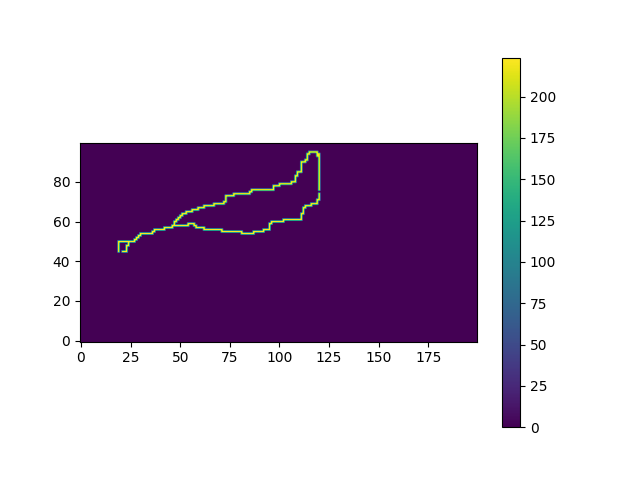

In [105]:
ca = Slime_CA(shape=(200,100), circle_type='approx', visualise_type='path')
starting_coords = (20, 45)
ca.add_food(starting_coords, radius=0)
ca.set_start(starting_coords)
ca.add_food((120, 75), radius=0)
ca.add_food((120, 95), radius=0)

animator = CA_Animator(ca)
animator.animate(frame_count=400, interval=0)

<IPython.core.display.Javascript object>


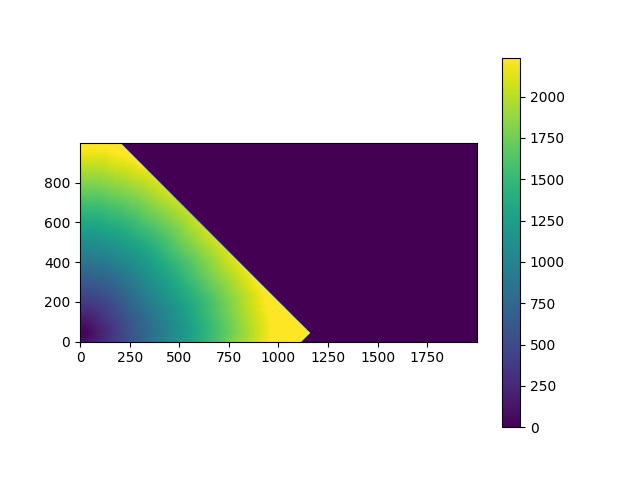

In [77]:
# ca = Slime_CA(shape=(2000,1000), circle_type='approx')
# starting_coords = (20, 45)
# ca.add_food(starting_coords, radius=0)
# ca.set_start(starting_coords)
# ca.add_food((1200, 750), radius=0)


# animator = CA_Animator(ca)
# animator.animate(frame_count=2000, interval=0)

In [96]:
ca = Slime_CA(shape=(200,100))
starting_coords = (20, 45)
ca.add_food(starting_coords, radius=0)
ca.set_start(starting_coords)
ca.add_food((120, 75), radius=0)

for _ in range(300):
    ca.slime_grid.step()

TypeError: circle_neighbours() got an unexpected keyword argument 'neighbourhood'

In [104]:
list(ca.slime_grid.distance_grids.values())[0].draw()